# Exploratory Data Analysis
This analysis was done on a subset of the review data for Las Vegas.  The data was chosed by first selecting a random sample of 200 open and 200 closed restaurants in Las Vegas which had between 100 and 300 reviews total.  This list of businesses was then joined to all the review data for those businesses.

---

In [2]:
# imports
import pandas as pd
import numpy as np
import string
import re
import pickle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

In [4]:
# read in review data sample
reviews = pd.read_csv('../data/Las_Vegas_400_reviews.csv')

In [5]:
reviews.head(2)

business_id           name           address       city state  \
0  409qhf4RF0rlxcuaM576Qg  El Pollo Loco  5260 S Ft Apache  Las Vegas    NV   
1  409qhf4RF0rlxcuaM576Qg  El Pollo Loco  5260 S Ft Apache  Las Vegas    NV   

   postal_code  latitude   longitude  stars  review_count  is_open  \
0        89148   36.0941 -115.296839    2.5           108        1   
1        89148   36.0941 -115.296839    2.5           108        1   

                                          attributes  \
0  {'RestaurantsAttire': "'casual'", 'GoodForKids...   
1  {'RestaurantsAttire': "'casual'", 'GoodForKids...   

                        categories  \
0  Restaurants, Mexican, Fast Food   
1  Restaurants, Mexican, Fast Food   

                                               hours                 user_id  \
0  {'Monday': '0:0-0:0', 'Tuesday': '9:30-23:0', ...  GmXOSEbXy8JXmvo9hM5WWQ   
1  {'Monday': '0:0-0:0', 'Tuesday': '9:30-23:0', ...  P8Rn03SOJg0NnExbOWhLZw   

   review_stars                                               text  \
0           2.0  Came here quickly today to grab a burrito with...   
1           1.0  I really like el pollo loco but some things no...   

                  date  
0  2015-09-09 23:09:37  
1  2014-04-20 03:16:46

## Feature Engineering

In [10]:
# Character count
reviews['char_count'] = reviews['text'].str.len()

# Word count
reviews['word_count'] = reviews['text'].str.split().str.len()

In [11]:
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# From DSI Lesson 5.04-NLP-II
def get_vader_neg(text):
    return analyzer.polarity_scores(text)['neg']
def get_vader_neu(text):
    return analyzer.polarity_scores(text)['neu']
def get_vader_pos(text):
    return analyzer.polarity_scores(text)['pos']
def get_vader_comp(text):
    return analyzer.polarity_scores(text)['compound']

reviews['vader_neg'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
reviews['vader_neu'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
reviews['vader_pos'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
reviews['vader_comp'] = reviews['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [12]:
# save with engineered features
reviews.to_csv('../data/reviews_with_eng_feats')

---

In [6]:
# read in review data with engineered features so it isn't necessary to run 
# sentiment analysis every time
reviews = pd.read_csv('../data/reviews_with_eng_feats', index_col=0)

In [7]:
# Separate into dataframes by open and closed
open_reviews = reviews.loc[reviews['is_open']==1]
closed_reviews = reviews.loc[reviews['is_open']==0]

## Initial Analysis

In [8]:
# number of unique businesses
len(reviews['business_id'].unique())

400

In [9]:
# count of reviews by open or closed
reviews['is_open'].value_counts()

1    37211
0    36067
Name: is_open, dtype: int64

In [10]:
# Correlation of stars to open or closed
reviews[['is_open', 'stars']].corr()

is_open     stars
is_open  1.000000  0.015415
stars    0.015415  1.000000

In [11]:
# Statistics of star ratings for closed
closed_reviews[['stars']].describe().T

count      mean       std  min  25%  50%  75%  max
stars  36067.0  3.714628  0.579305  2.0  3.5  3.5  4.0  5.0

In [12]:
# Statistics of star ratings for open
open_reviews[['stars']].describe().T

count      mean       std  min  25%  50%  75%  max
stars  37211.0  3.733882  0.665168  1.5  3.5  4.0  4.0  5.0

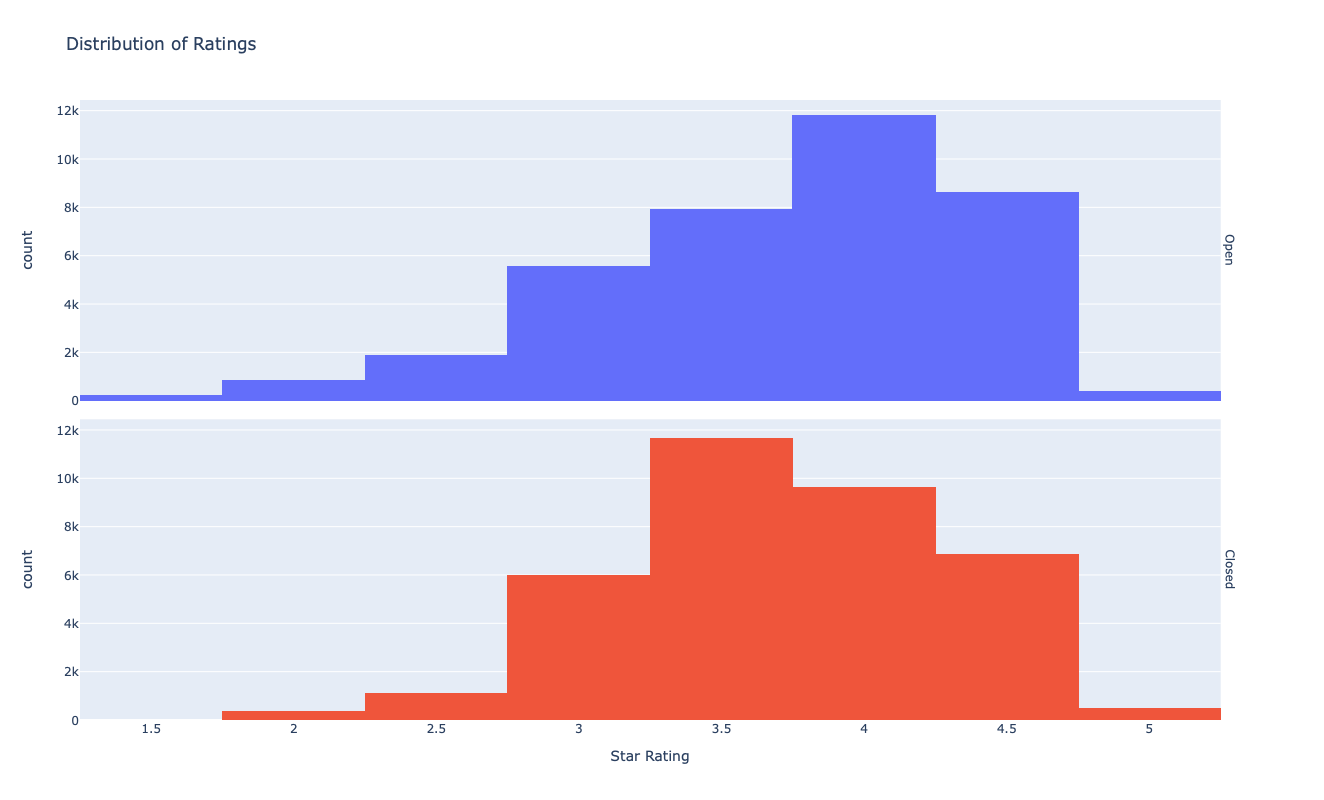

In [69]:
# Plot distribution of ratings open and closed restaurants
fig = px.histogram(reviews, x='stars', title='Distribution of Ratings', 
                   facet_row='is_open', color='is_open',
                   labels={'stars': 'Star Rating'})
fig.for_each_annotation(lambda a: a.update(text='Open') if a.text=='is_open=1' 
                        else a.update(text='Closed'))
fig.update_layout(height=800, width=900, showlegend=False)
fig.show()
#fig.write_image('../presentation/images/star_rating_dist.png')

#### Results
The number of stars is not highly related to whether or not the restaurant is open or closed.  Star ratings seem to be mostly positive, even for the restaurants that are closed.

## Character and Word Count Distributions

#### Character

In [13]:
# Closed restaurants review length statistics
closed_reviews[['char_count']].describe().T

count       mean         std  min    25%    50%    75%     max
char_count  36067.0  608.89636  578.691028  5.0  230.0  420.0  781.0  4999.0

In [14]:
# Open restaurants review length statistics
open_reviews[['char_count']].describe().T

count        mean         std  min    25%    50%    75%     max
char_count  37211.0  489.005402  457.449748  5.0  199.0  342.0  615.0  5000.0

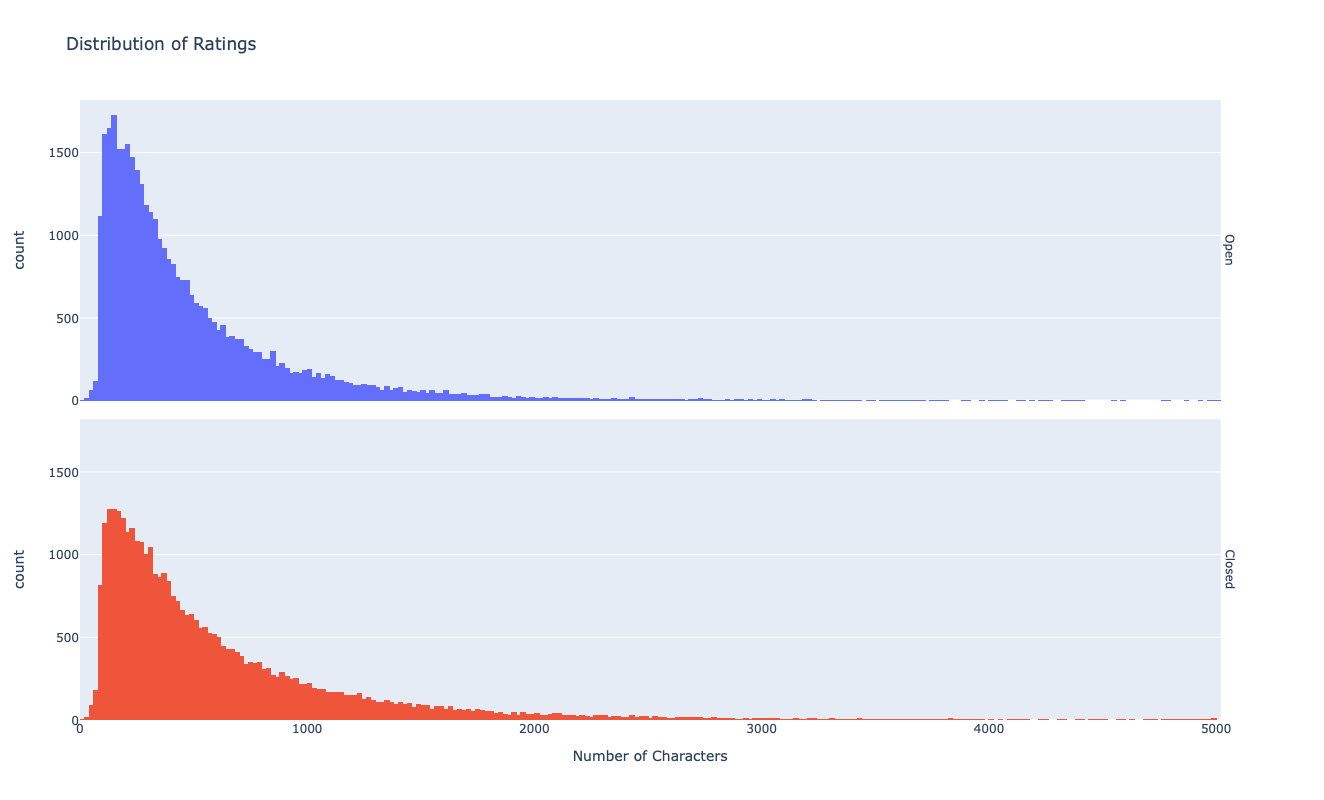

In [70]:
# Plot distribution of ratings open and closed restaurants
fig = px.histogram(reviews, x='char_count', title='Distribution of Ratings', 
                   facet_row='is_open', color='is_open',
                   labels={'char_count': 'Number of Characters'})
fig.for_each_annotation(lambda a: a.update(text='Open') if a.text=='is_open=1' 
                        else a.update(text='Closed'))
fig.update_layout(height=800, width=900, showlegend=False)
fig.show()
#fig.write_image('../presentation/images/char_count_dist.png')

- Character limit for Yelp reviews appears to be 5000
- From: https://www.yelp.com/topic/exton-long-review-exceeding-the-maximum-character-allowance

#### Words

In [15]:
# Closed restaurants review length statistics
closed_reviews[['word_count']].describe().T

count        mean         std  min   25%   50%    75%    max
word_count  36067.0  112.685142  106.670853  1.0  42.0  78.0  145.5  965.0

In [16]:
# Open restaurants review length statistics
open_reviews[['word_count']].describe().T

count       mean        std  min   25%   50%    75%    max
word_count  37211.0  91.071189  85.492903  1.0  36.0  64.0  115.0  972.0

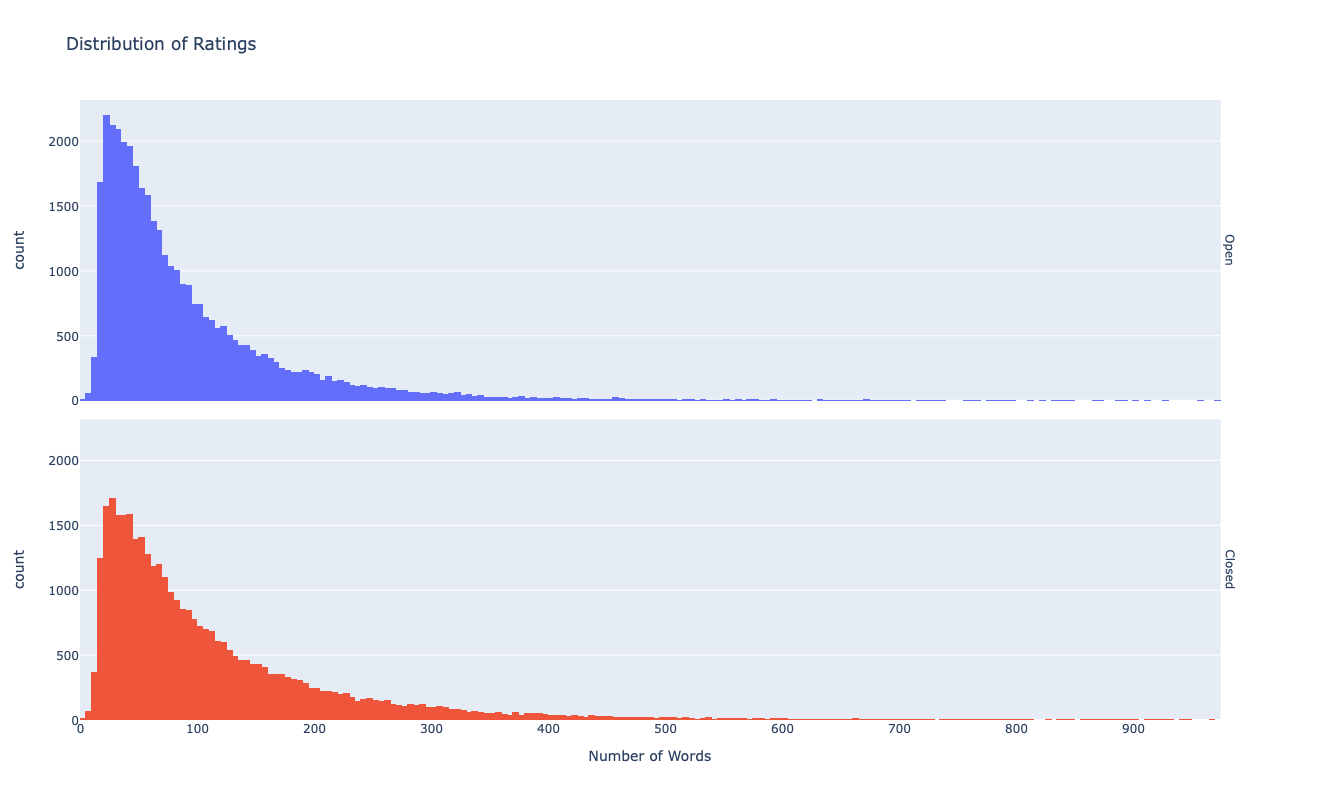

In [73]:
# Plot distribution of ratings open and closed restaurants
fig = px.histogram(reviews, x='word_count', title='Distribution of Ratings', 
                   facet_row='is_open', color='is_open',
                   labels={'word_count': 'Number of Words'})
fig.for_each_annotation(lambda a: a.update(text='Open') if a.text=='is_open=1' 
                        else a.update(text='Closed'))
fig.update_layout(height=800, width=900, showlegend=False)
fig.show()
#fig.write_image('../presentation/images/word_count_dist.png')

#### Results
For both character count and word count, the distributions are of similar shape.  However in both cases, there are more short reviews for open businesses with a steep drop off as the number of words or characters increase.  The drop off for closed businesses is a little more gradual.  This can be seen by the mean and standard deviation as well.

## Most Frequent Words

In [75]:
# using isalnum method to remove special characters from
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string

def my_preprocessor(text):
    """Process text for use with vectorizer.
    
    Takes in a string and modifies it for use with count or tf-idf
    vectorizer.  It will set all characters to lowercase, remove and urls,
    remove the apostrophe from contractions, and replace non-alphanumeric
    characters with a space.
    
    Args:
        text (string): string to be processed
    
    Returns:
        string: processed text string
    """
    text = text.lower()
    text = re.sub('http\S+|www.\S+', '', text)
    text = text.replace("'", '')
    text = ''.join(w if w.isalnum() or w == ' ' else ' ' for w in text)
    
    return text

In [76]:
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in word_tokenize(text)]

In [77]:
# Download stopwords from nltk
# Uncomment line below and run if necessary
#nltk.download('stopwords')

In [78]:
# apply same pre-processing as reviews to stopwords
# inspiration from https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w.replace("'",'')) for w in stopwords.words('english')]

In [114]:
cvect = CountVectorizer(
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords,
    max_features=500
)

In [115]:
# Vectorize open reviews and create dataframe with words and counts
open_vect = cvect.fit_transform(open_reviews['text'])
open_dtm = pd.DataFrame(open_vect.toarray(), columns = cvect.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect = cvect.fit_transform(closed_reviews['text'])
closed_dtm = pd.DataFrame(closed_vect.toarray(), columns = cvect.get_feature_names())

In [ ]:
fig = px.bar(long_bigram_df_tidy, title='Comparision: ' + ngrams_list[0] + ' | ' + ngrams_list[1], x='ngram', y='value'
             , color='variable', template='plotly_white', color_discrete_sequence=px.colors.qualitative.Bold
             , labels={'variable': 'Company:', 'ngram': 'N-Gram'})
fig.update_layout(legend_orientation="h")
fig.update_layout(legend=dict(x=0.1, y=1.1))
fig.update_yaxes(title='', showticklabels=False)
fig.show()

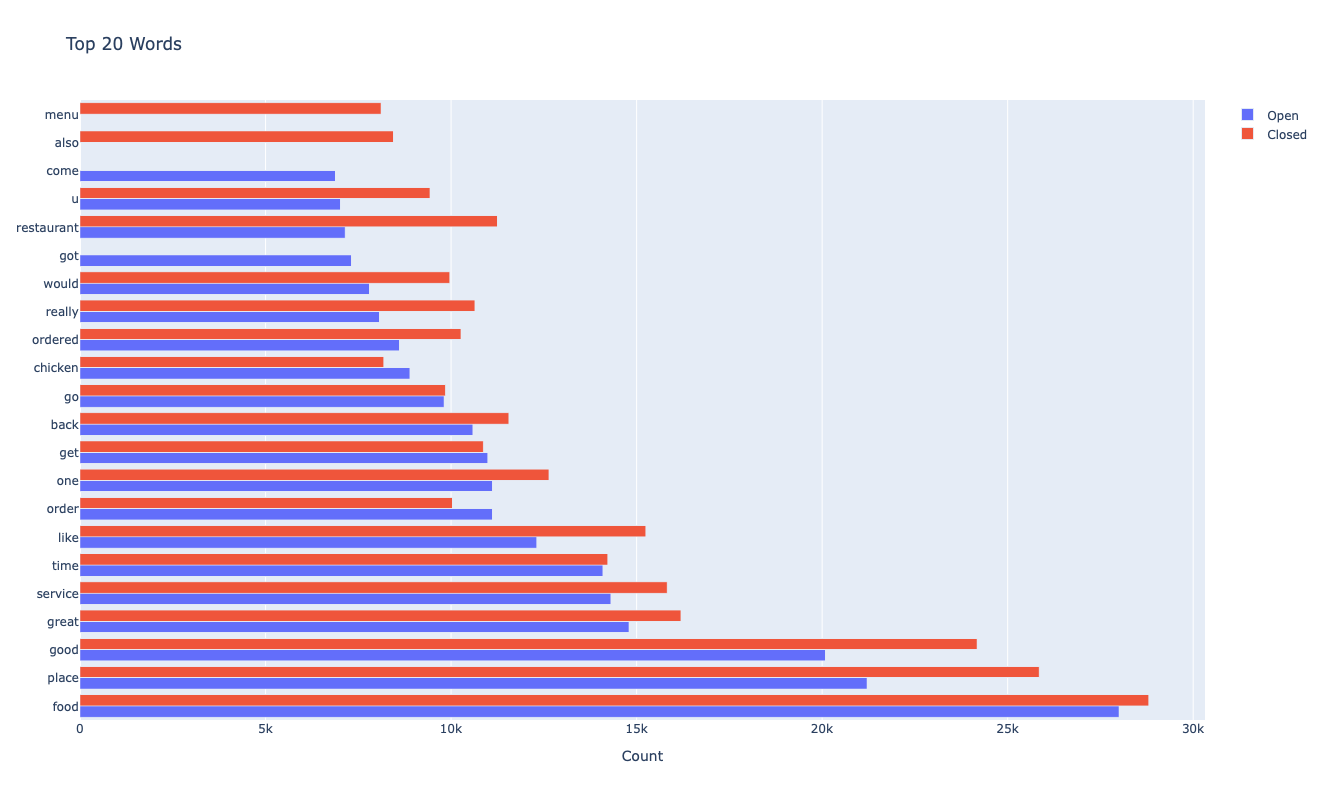

In [130]:
#Plot top 20 words for each open and closed
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Bar(y=open_dtm.sum().sort_values(ascending=False).head(20).index,
           x=open_dtm.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Open')
)

fig.add_trace(
    go.Bar(y=closed_dtm.sum().sort_values(ascending=False).head(20).index,
           x=closed_dtm.sum().sort_values(ascending=False).head(20), orientation='h', 
           name='Closed')
)

fig.update_layout(
    title='Top 20 Words',
    xaxis_title='Count',
    height=800,
    width =800
)

#fig.write_image('../presentation/images/top_20_words.png')
fig.show()

#### Bigrams

In [118]:
cvect2 = CountVectorizer(
    ngram_range=(2,2),
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords,
    max_features=500
)

In [119]:
# Vectorize open reviews and create dataframe with words and counts
open_vect2 = cvect2.fit_transform(open_reviews['text'])
open_dtm2 = pd.DataFrame(open_vect2.toarray(), columns = cvect2.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect2 = cvect2.fit_transform(closed_reviews['text'])
closed_dtm2 = pd.DataFrame(closed_vect2.toarray(), columns = cvect2.get_feature_names())

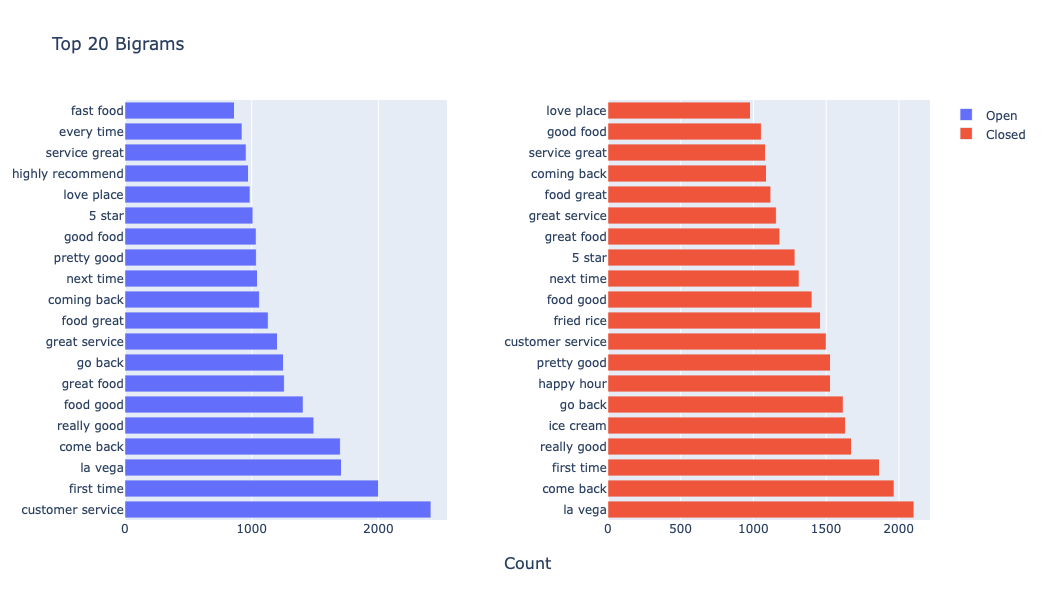

In [130]:
#Plot top 20 bigrams for each open and closed
fig = make_subplots(rows=1, cols=2, x_title='Count',
                    horizontal_spacing=0.2)

fig.add_trace(
    go.Bar(y=open_dtm2.sum().sort_values(ascending=False).head(20).index,
           x=open_dtm2.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Open'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(y=closed_dtm2.sum().sort_values(ascending=False).head(20).index,
           x=closed_dtm2.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Closed'),
    row=1, col=2
)

fig.update_layout(
    title='Top 20 Bigrams',
    height=600,
    width=900
)

#fig.write_image('../presentation/images/top_20_bigrams.png')
fig.show()

#### Trigrams

In [111]:
cvect3 = CountVectorizer(
    ngram_range=(3,3),
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords,
    max_features=500
)

In [112]:
# Vectorize open reviews and create dataframe with words and counts
open_vect3 = cvect3.fit_transform(open_reviews['text'])
open_dtm3 = pd.DataFrame(open_vect3.toarray(), columns = cvect3.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect3 = cvect3.fit_transform(closed_reviews['text'])
closed_dtm3 = pd.DataFrame(closed_vect3.toarray(), columns = cvect3.get_feature_names())

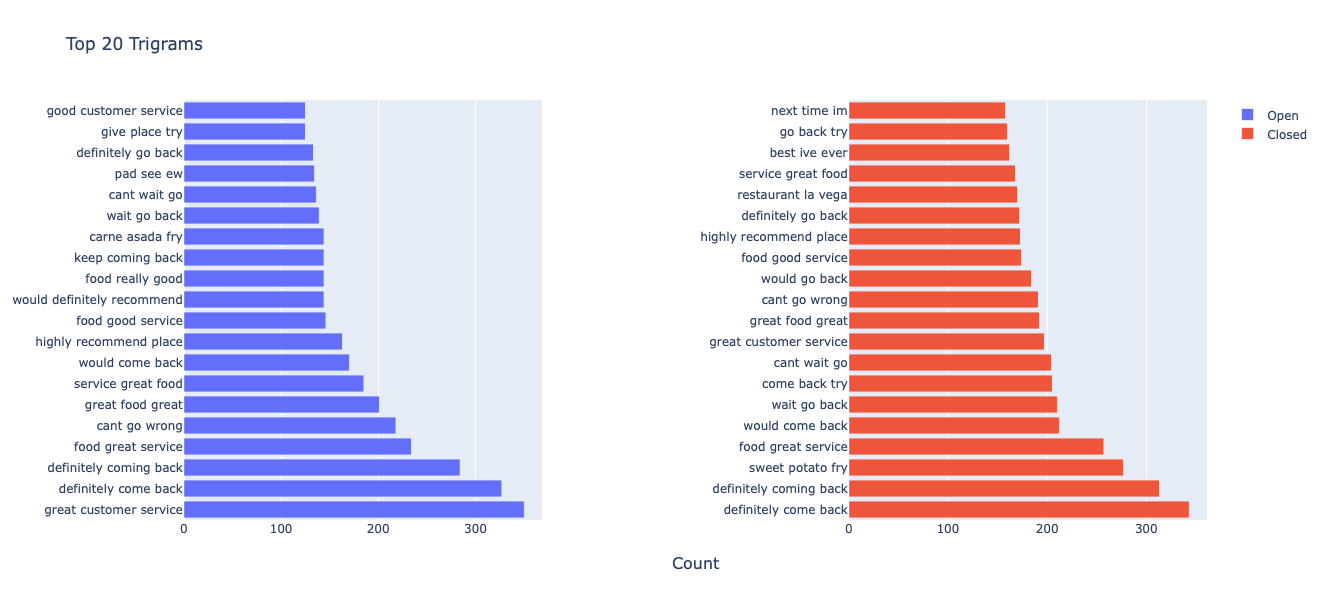

In [113]:
#Plot top 20 trigrams for each open and closed
fig = make_subplots(rows=1, cols=2, x_title='Count',
                    horizontal_spacing=0.3)

fig.add_trace(
    go.Bar(y=open_dtm3.sum().sort_values(ascending=False).head(20).index,
           x=open_dtm3.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Open'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(y=closed_dtm3.sum().sort_values(ascending=False).head(20).index,
           x=closed_dtm3.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Closed'),
    row=1, col=2
)

fig.update_layout(
    title='Top 20 Trigrams',
    height=600,
    width=900
)

#fig.write_image('../presentation/images/top_20_trigrams.png')
fig.show()

#### Results
The most frequent words are very similar betweenopen and closed restaurants.  Even for bigrams and trigrams, the phrases or mostly positive for both open and closed restaurants.  If there are differences in the review words between open and closed restaurants, they must be further down the list in terms of frequency.  Looking at feature importances when modeling could illuminate this.

## Sentiment Analysis

In [82]:
sent_cols = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_comp']

In [85]:
# Correlation of Vader Sentiment to open / closed and star rating
corr_cols = sent_cols.copy()
corr_cols.append('stars')
corr_cols.append('is_open')
reviews[corr_cols].corr()

vader_neg  vader_neu  vader_pos  vader_comp     stars   is_open
vader_neg    1.000000   0.023895  -0.472359   -0.734676 -0.248377  0.014988
vader_neu    0.023895   1.000000  -0.892436   -0.292571 -0.177819 -0.018105
vader_pos   -0.472359  -0.892436   1.000000    0.589505  0.268872  0.009192
vader_comp  -0.734676  -0.292571   0.589505    1.000000  0.285103 -0.053892
stars       -0.248377  -0.177819   0.268872    0.285103  1.000000  0.015415
is_open      0.014988  -0.018105   0.009192   -0.053892  0.015415  1.000000

In [43]:
# 10 reviews with most negative sentiment
reviews.sort_values('vader_neg', ascending=False)['text'][:10]

41994    Dirty floors, Dirty tables, Terrible customer ...
21390    disgusting kitchen area, rude service and the ...
4202     Rude and Obnoxious Owner/Server, Very High pri...
4874     Avoid at all costs. Horrible service and horri...
11807    Bad customer service and very bad pho not reco...
35745    Food were too salty. The waitress was rude unp...
68807    Terrible. Don't go even if you're forced to.Wa...
5143     Worst place ever.    Food sucks!!! The bar is ...
52667                             Nıce margarita bad food.
11184    Worst experience they lie about changing recip...
Name: text, dtype: object

In [47]:
# 10 reviews with most positive sentiment
reviews.sort_values('vader_pos', ascending=False)['text'][:10]

23153                                                Yummy
35928                                     amazing meal!!!!
38254                                     awesome falafel!
68042    Friendly attentive service, peaceful, enjoyabl...
44033                           Hand down Best Falafels!!!
59457    Great tacos, great atmosphere, awesome taco's....
55133    Great service, great food, good burgers, great...
63315               Sooo good. Love tigers blood. Winning!
65428         Pretty solid chicken.  Nice clean place too!
65120    Super fabulous food!!!  Nice atmosphere and gr...
Name: text, dtype: object

In [39]:
open_reviews[sent_cols].describe()

vader_neg     vader_neu     vader_pos    vader_comp
count  37211.000000  37211.000000  37211.000000  37211.000000
mean       0.043297      0.751118      0.205585      0.618204
std        0.057498      0.110832      0.126943      0.573986
min        0.000000      0.000000      0.000000     -0.998000
25%        0.000000      0.687000      0.110000      0.592700
50%        0.024000      0.767000      0.189000      0.906900
75%        0.066000      0.829000      0.284000      0.966400
max        0.605000      1.000000      1.000000      0.999800

In [41]:
closed_reviews[sent_cols].describe()

vader_neg     vader_neu     vader_pos    vader_comp
count  36067.000000  36067.000000  36067.000000  36067.000000
mean       0.041632      0.755046      0.203323      0.678071
std        0.053370      0.105888      0.118789      0.533779
min        0.000000      0.168000      0.000000     -0.998600
25%        0.000000      0.697000      0.118000      0.716100
50%        0.026000      0.771000      0.187000      0.928700
75%        0.061000      0.828000      0.271000      0.975400
max        0.628000      1.000000      0.832000      0.999800

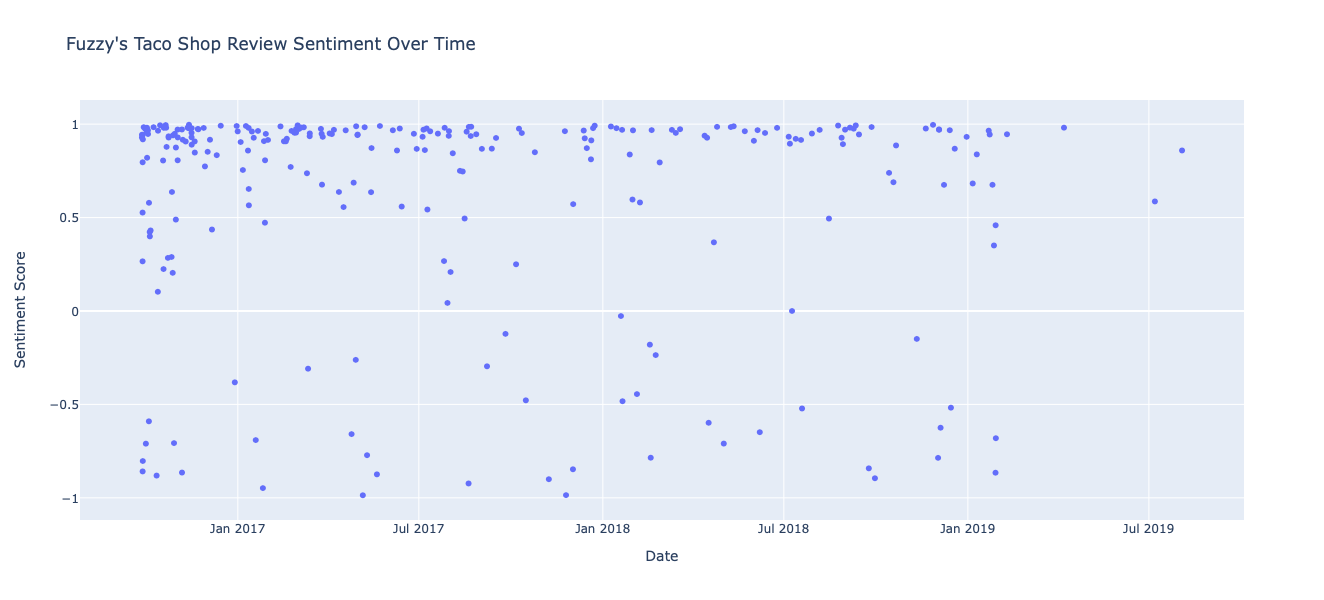

In [88]:
# Example Sentiment Over Time for closed restaurant
closed_id = 'INzLc1Y0JNQzIHjPH2Nbeg'
closed_sent = reviews.loc[reviews['business_id']==closed_id][['name','date','vader_comp']]
fig = px.scatter(closed_sent, x='date', y='vader_comp', 
                 title=f"{closed_sent['name'].values[0]} Review Sentiment Over Time",
                 labels={'date': 'Date', 'vader_comp': 'Sentiment Score'})

fig.update_layout(
    height=600,
    width=900
)

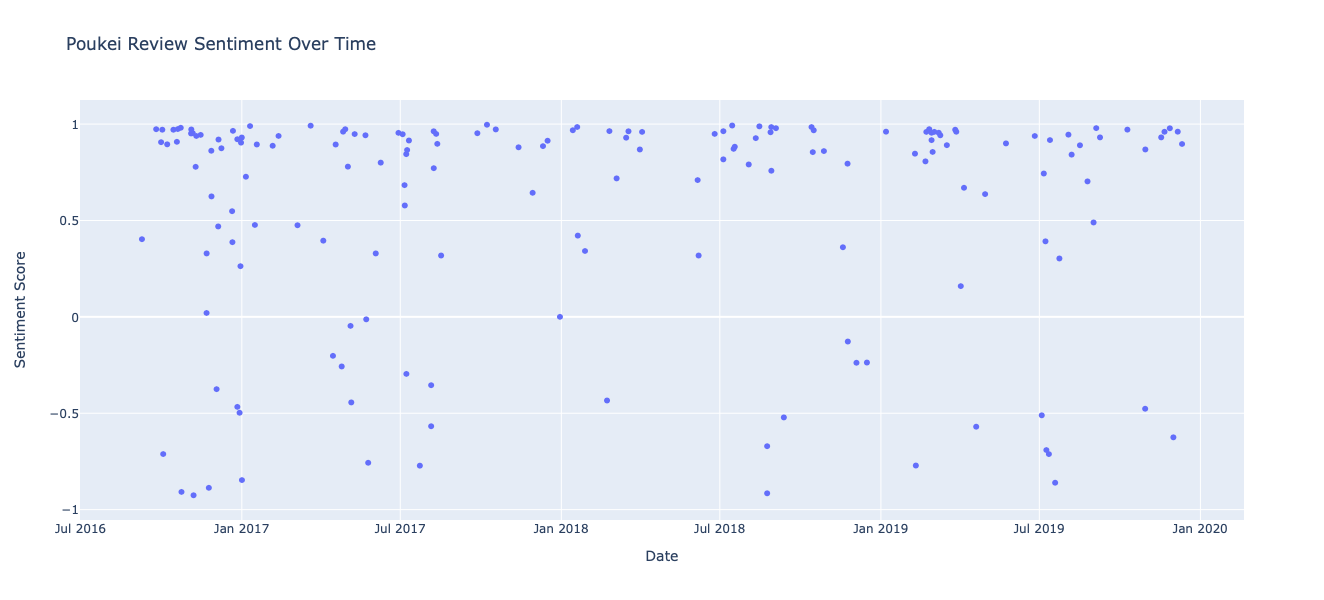

In [89]:
# Example Sentiment Over Time for open restaurant
open_id = 'K19uBHydrYAsfX3CPnFp-w'
open_sent = reviews.loc[reviews['business_id']==open_id][['name','date','vader_comp']]
fig = px.scatter(open_sent, x='date', y='vader_comp', 
                 title=f"{open_sent['name'].values[0]} Review Sentiment Over Time",
                 labels={'date': 'Date', 'vader_comp': 'Sentiment Score'})

fig.update_layout(
    height=600,
    width=900
)

#### Average of Sentiment Per Business

In [53]:
business_sentiment = pd.DataFrame(reviews['business_id'].value_counts())
business_sentiment = business_sentiment.merge(
    reviews.groupby('business_id')[['vader_comp', 'is_open']].mean(),
    how='left', left_index=True, right_on='business_id'
)

business_sentiment.head(2)

business_id  vader_comp  is_open
business_id                                             
vFfU79z5a5jQaQA_ka2ftA          312    0.711128        1
fpM-O9Ul62xizBq9YNO_tQ          312    0.531959        1

In [61]:
business_sentiment['open_cat'] = np.where(business_sentiment['is_open']==1, 'Open', 'Closed')

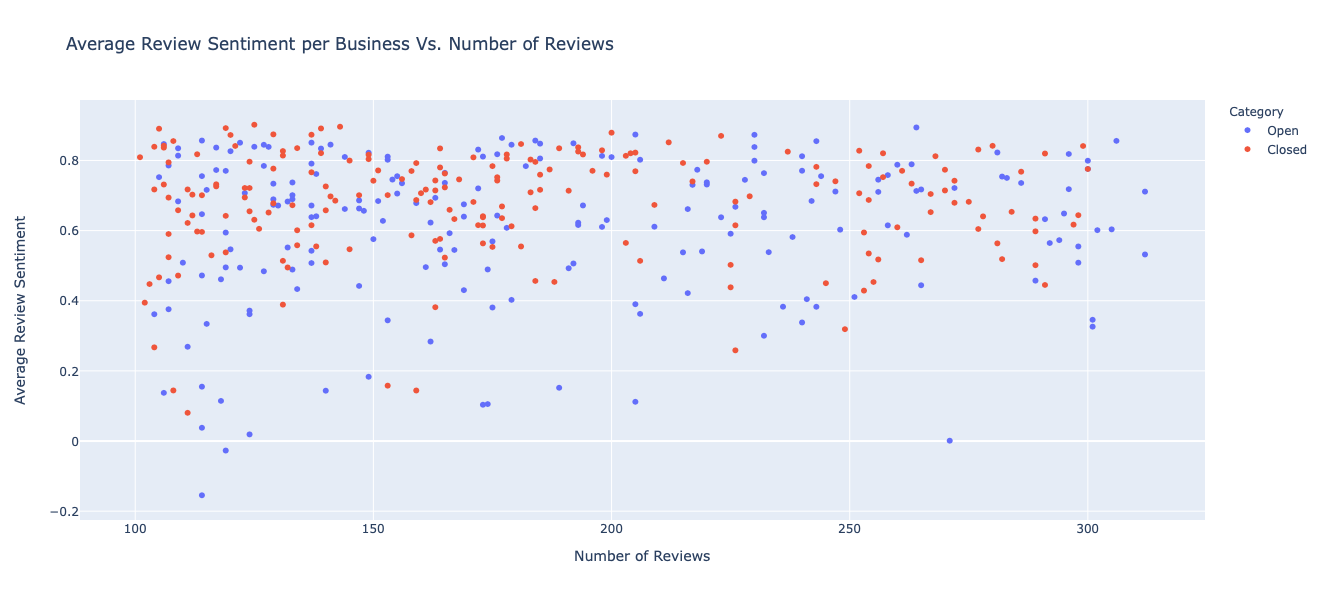

In [95]:
fig = px.scatter(business_sentiment, x='business_id', y='vader_comp', color='open_cat',
                 title="Average Review Sentiment per Business Vs. Number of Reviews",
                 labels={'business_id': 'Number of Reviews',
                         'vader_comp': 'Average Review Sentiment',
                         'open_cat': 'Category'})

fig.update_layout(
    height=600,
    width=900
)

#fig.write_image('../presentation/images/sentiment_per_business.png')
fig.show()

#### Results
Although the vader sentiment seems to have done a pretty good job detecting the most positive and negative reviews, it does not not seem to be highly correltated to whether or not the restaurant is open.  It is, however, related to the star rating of the restaurant.

## Model Feature Importances
Word counts based on the most important features from modeling

In [98]:
# Read in saved feature importances
with open('../data/logreg_imports.data', 'rb') as f:
    logreg_imports = pickle.load(f)
    
with open('../data/adaboost_imports.data', 'rb') as f:
    adaboost_imports = pickle.load(f)

In [124]:
logreg_imports.sort_values('importance', ascending=False).head(10)

importance
favorite    0.501412
choice      0.499607
fun         0.493925
rude        0.449316
pay         0.442830
want        0.432303
craving     0.427944
fast        0.423760
lol         0.420031
let         0.403932

In [100]:
logreg_imports.shape

(60, 1)

In [125]:
adaboost_imports.sort_values('importance', ascending=False).head(10)

importance
thank             0.04
gave              0.03
reasonable        0.03
rude              0.03
come              0.02
yelp              0.02
wrong             0.02
favorite          0.02
easy              0.02
stuff             0.02

In [102]:
adaboost_imports.shape

(60, 1)

In [103]:
custom_vocab = set(list(logreg_imports.index) + list(adaboost_imports.index))

In [104]:
custom_vocab_cv = CountVectorizer(
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    vocabulary=custom_vocab
)

#### Most Common words for Open / Closed Restaurants Separately

In [105]:
# Vectorize open reviews and create dataframe with words and counts
open_vect4 = custom_vocab_cv.fit_transform(open_reviews['text'])
open_dtm4 = pd.DataFrame(open_vect4.toarray(), columns = custom_vocab_cv.get_feature_names())

# Vectorize closed reviews and create dataframe with words and counts
closed_vect4 = custom_vocab_cv.fit_transform(closed_reviews['text'])
closed_dtm4 = pd.DataFrame(closed_vect4.toarray(), columns = custom_vocab_cv.get_feature_names())

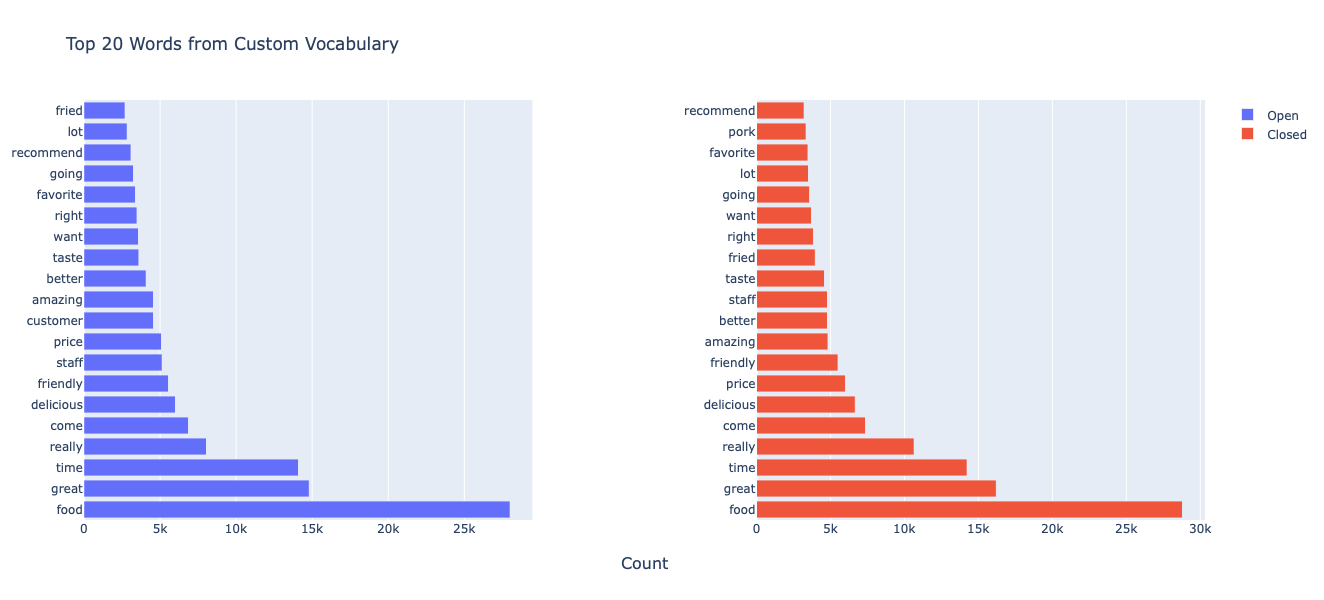

In [106]:
#Plot Word counts for custom vocabulary
fig = make_subplots(rows=1, cols=2, x_title='Count',
                    horizontal_spacing=.2)

fig.add_trace(
    go.Bar(y=open_dtm4.sum().sort_values(ascending=False).head(20).index,
           x=open_dtm4.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Open'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(y=closed_dtm4.sum().sort_values(ascending=False).head(20).index,
           x=closed_dtm4.sum().sort_values(ascending=False).head(20), orientation='h',
           name='Closed'),
    row=1, col=2
)

fig.update_layout(
    title='Top 20 Words from Custom Vocabulary',
    height=600,
    width =900
)

#fig.write_image('../presentation/images/custom_vocab_separate.png')
fig.show()